In [1]:
!pip install mynn
!pip install cogworks-data
!pip install gensim
!pip mygrad as mg
!pip install matplotlib

ERROR: unknown command "mygrad"


In [2]:
from cogworks_data.language import get_data_path

from pathlib import Path
import json

from gensim.models import KeyedVectors

import pickle
import re
import string

from mynn.layers import dense
from mynn.initializers import glorot_normal
import mygrad as mg
from mynn.optimizers.sgd import SGD

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
import io

In [3]:
class COCO:
    def __init__(self):

        image_ids = list()
        caption_ids = list()
        image_to_captions = {}
        caption_to_image = {}
        caption_to_text = {}

        self.image_ids = image_ids
        self.caption_ids = caption_ids
        self.image_to_captions = image_to_captions
        self.caption_to_image = caption_to_image
        self.caption_to_text = caption_to_text

        filename = get_data_path("captions_train2014.json")
        with Path(filename).open() as f:
            coco_data = json.load(f)

        self.coco_data = coco_data

        
        with Path(get_data_path('resnet18_features.pkl')).open('rb') as f:
            self.resnet18_features = pickle.load(f)

        for image_info in coco_data['images']:
            if image_info["id"] in self.resnet18_features:
                image_ids.append(image_info['id'])
            
        for caption_info in coco_data['annotations']:
            if caption_info['image_id'] in self.resnet18_features:
                caption_id = caption_info['id']
                image_id = caption_info['image_id']

                caption_ids.append(caption_id)
                
                if image_id not in image_to_captions:
                    image_to_captions[image_id] = []
                image_to_captions[image_id].append(caption_id)

                caption_to_image[caption_id] = image_id

                caption_to_text[caption_id] = caption_info['caption']

    def get_image_to_caption(self, image_id):
        return self.image_to_captions[image_id]

    def get_caption_to_image(self, caption_id):
        return self.caption_to_image[caption_id]
    
    def get_caption_to_text(self, caption_id):
        return self.caption_to_text[caption_id]

    def get_resnet_features(self, image_id):
        return self.resnet18_features[image_id]

    def get_all_captions(self):
        return list(self.caption_to_text.values())

In [40]:
class EmbeddingModel:
    def __init__(self):
        self.linear1 = dense(512, 200, weight_initializer=glorot_normal)
    def __call__(self, x):
        output = self.linear1(x) 
        return output / mg.linalg.norm(output)
    @property
    def parameters(self):
        return self.linear1.parameters

In [5]:
def custom_loss(true_embedding, confusor_embedding, caption_embedding):
    print(true_embedding.shape, confusor_embedding.shape, caption_embedding.shape)
    sim_true = mg.einsum("nd,nd -> n", true_embedding, caption_embedding)
    sim_confusor = mg.einsum("nd,nd -> n", confusor_embedding, caption_embedding)
    return mg.nnet.losses.margin_ranking_loss(sim_true, sim_confusor, 1, margin=0.25)

In [6]:
def get_triplet_batch(coco_data_organizer):
    triplet_batch = []
    num_captions = len(coco_data_organizer.caption_ids)

    for i in range(num_captions):
        caption_id = coco_data_organizer.caption_ids[i]
        true_image_id = coco_data_organizer.get_caption_to_image(caption_id)

        if i < num_captions - 1:
            confusor_caption_id = coco_data_organizer.caption_ids[i + 1]
            confusor_image_id = coco_data_organizer.get_caption_to_image(confusor_caption_id)
        else:
            confusor_caption_id = coco_data_organizer.caption_ids[0]
            confusor_image_id = coco_data_organizer.get_caption_to_image(confusor_caption_id)

        triplet_batch.append([caption_id, true_image_id, confusor_image_id])

    np.random.shuffle(triplet_batch)
    return triplet_batch


In [41]:
coco = COCO()
batch_size = 32
model = EmbeddingModel()
lr = 1e-3
momentum = 0.9
optimizer = SGD(model.parameters, learning_rate=lr, momentum = momentum)

In [25]:
triplet_data = get_triplet_batch(coco)
num_triplets = len(triplet_data)
train_size = 3000

train_data = np.array(triplet_data[:train_size])
test_data = triplet_data[train_size:]

train_indices = list(range(train_size))

In [9]:
import re, string
punc_regex = re.compile('[{}]'.format(re.escape(string.punctuation)))
def strip_punc(corpus):
    """ Removes all punctuation from a string.
        
    Parameters
    ----------
    corpus : str

    Returns
    -------
    str
        the corpus with all punctuation removed"""
    # substitute all punctuation marks with ""
    return punc_regex.sub('', corpus)

In [10]:
with open("IDF_mappings.pkl","rb") as file_name:
    IDF = pickle.load(file_name)

In [11]:
from gensim.models import KeyedVectors
filename = "glove.6B.200d.txt.w2v"

# this takes a while to load -- keep this in mind when designing your capstone project
glove = KeyedVectors.load_word2vec_format(get_data_path(filename), binary=False)

In [12]:
def computer_caption_embedding(caption:str): 
    embedding = 0.0
    new_caption = strip_punc(caption).lower().split()
    for word in new_caption:
        if word not in glove or word not in IDF:
            embedding += np.zeros(glove.vector_size)
        else:
            embedding += glove[word] * IDF[word]

    return embedding / np.linalg.norm(embedding)

In [ ]:
caption_embeddings = {}
for caption_id in coco_data_organizer.caption_ids:
    cap_text = coco_data_organizer.get_caption_to_text(caption_id)
    caption_embeddings[caption_id] = computer_caption_embedding(cap_text)

with open("caption_embeddings.pkl", 'wb') as fout:
    pickle.dump(caption_embeddings, fout)

In [42]:
test = model.parameters 

for epoch in range(10):
    total_loss = 0.0
    for i in range(0, train_size // batch_size):
        batch_idxs = train_indices[i * batch_size : (i + 1) * batch_size]

        caption_ids = train_data[batch_idxs][:, 0]
        true_image_ids = train_data[batch_idxs][:, 1]
        confusor_image_ids = train_data[batch_idxs][:, 2]

        true_caption_embeddings = [caption_embeddings[caption_id] for caption_id in caption_ids]
        true_caption_embeddings = np.array(true_caption_embeddings)

        true_images_desc = [coco.get_resnet_features(image_id) for image_id in true_image_ids]
        true_images_desc = np.vstack(true_images_desc)

        confusor_image_desc = [coco.get_resnet_features(image_id) for image_id in confusor_image_ids]
        confusor_image_desc = np.vstack(confusor_image_desc)

        # print(true_caption_embeddings[0], true_images_desc[0], confusor_image_desc[0])
        true_embeddings = model(true_images_desc)
        print(true_embeddings._creator)

        confusor_embeddings = model(confusor_image_desc)
        print(type(true_embeddings), type(confusor_embeddings))

        sim_true = mg.einsum("nd,nd -> n", true_embeddings, true_caption_embeddings)
        sim_confusor = mg.einsum("nd,nd -> n", confusor_embeddings, true_caption_embeddings)
        loss = mg.nnet.losses.margin_ranking_loss(sim_true, sim_confusor, 1, margin=0.25)

        loss.backward()
        # print(optimizer.params)
        optimizer.step()

        total_loss += loss.item()
        print(model.parameters == test)
        test = model.parameters
        print(loss.item())
    avg_loss = total_loss / (train_size // batch_size)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")
    break

    

[ 1.33611113e-02  7.04798056e-03 -1.80024691e-02 -3.81754003e-02
  5.30059962e-03  6.30221739e-02 -1.92328617e-02 -3.59551497e-02
 -5.19812256e-02 -4.75873686e-02 -1.89717207e-02  4.28730287e-02
  1.07170634e-01  5.97912222e-02  6.77105598e-03  1.57189369e-02
 -3.75952087e-02  8.50203389e-04 -2.62806937e-02 -1.67575050e-02
  7.47463107e-02  5.84204793e-01  7.45440796e-02 -5.76647222e-02
  4.21728678e-02 -7.41762146e-02 -4.04907204e-02 -3.38043161e-02
 -5.52324653e-02  3.98109704e-02  5.93564659e-02  4.04463671e-02
  4.41294350e-02  4.74497490e-02 -7.20941648e-02 -1.98189840e-02
 -1.22479443e-02 -7.96235725e-02  1.67078767e-02  2.79908329e-02
 -2.47499235e-02  4.86738374e-03 -2.72641759e-02  2.54177004e-02
 -1.24603892e-02  6.81447983e-02  1.27864003e-01 -9.45423618e-02
 -2.92276349e-02  8.94717053e-02 -5.51841967e-03  7.08918348e-02
 -3.71237732e-02  1.01187304e-01  7.74492398e-02 -5.78369712e-03
 -6.44078031e-02  2.85370811e-03  5.42293675e-03  6.31639659e-02
  7.15218782e-02  4.85611

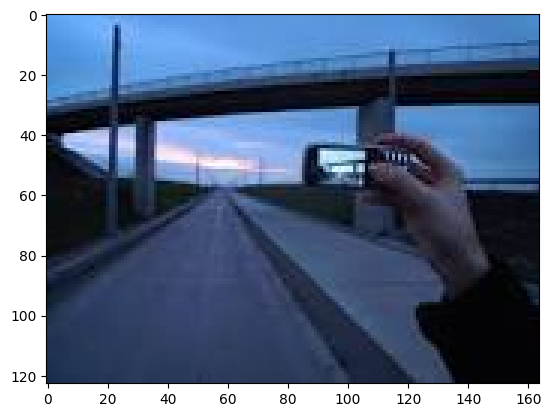

In [ ]:
database = {}

def add_image_embeddings():
    for image_id in coco_data_organizer.image_ids:
        database[image_id] = model(coco_data_organizer.get_resnet_features(image_id))

def query_db(caption_embedding, top_k=3):
    N = len(database)

    a = caption_embedding
    b = np.stack(database.values())

    similarities = (np.einsum('ij,kj->ki',a,b)/np.linalg.norm(a)).reshape(N)/np.linalg.norm(b, axis=1)
    idxs = np.argpartition(similarities, -top_k)[-top_k:]

    return (np.stack(database.keys())[idxs]).tolist(), similarities[idxs]

def display_images(urls):
    k = len(urls)
    fig, ax = plt.subplots(k)

    if k==1:
        response = requests.get(urls[0])
        ax.imshow(Image.open(io.BytesIO(response.content)))
    else:
        for url_idx in range(k):
            response = requests.get(urls[url_idx])
            ax[url_idx].imshow(Image.open(io.BytesIO(response.content)))

    plt.show()

display_images(["https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTHZAq08u4YaR0Jsu2CgeptdxC74y-9QEeFYEAb6YHP&s"])

In [ ]:
coco_data_organizer = COCO()
arr = np.array(coco_data_organizer.image_ids)
shape = arr.shape
print(shape)

NameError: name 'COCO' is not defined

In [ ]:
# find the number captions
# (3,N) where N = # of captions
# create triplet data
# iterate through captions
# [caption_id, corresponding_true_image_id, confusor_image_id]
# Final check to make sure that true image != confusor image_id after shuffle
# Train test split (80% train, 20% test)
# (3,N)[0:80%] --> model 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b1b64d7a-730e-4263-8de6-f9465635e0aa' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>